In [ ]:
# imports 
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


In [89]:
# Download MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())


In [90]:
# get all the images of zeros in the mnist dataset
zero_images = [img for img in train_dataset if img[1] == 0]

In [91]:
# from here on out, we will deal with the flattened images only (vectors)
zero_vectors = []
for img, label in zero_images:
    flattened = img.squeeze().numpy().flatten()
    zero_vectors.append(flattened)

# stack vectors into a matrix
zero_matrix = np.array(zero_vectors)

# double check that the values are between 0 and 1
zero_matrix = np.clip(zero_matrix, 0.0, 1.0)

# scale from [0, 1] to [-1, 1] to match ddpm paper
zero_matrix = 2.0 * zero_matrix - 1.0


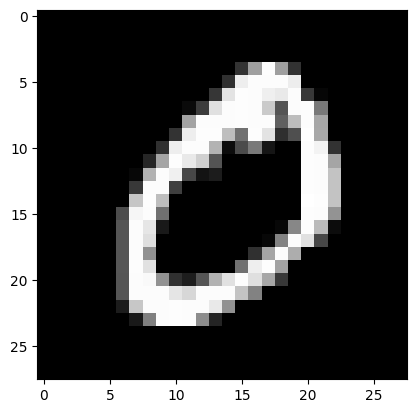

In [92]:
# im show an column in the zero matrix 
im = zero_matrix[0].reshape(28, 28)
# Convert from [-1, 1] to [0, 1] for visualization
im_viz = (im + 1.0) / 2.0
plt.imshow(im_viz, cmap='gray', vmin=0, vmax=1)
plt.show()



In [93]:
T = 1000

# precompute the alpha and beta coefficients for all the time steps
beta_dict = {}
alpha_dict = {}
for t in range(T + 1):  # 0 to T
    # in ddpm paper, beta is linearly interpoled from 10^-4 to 0.02
    beta_val = 10**-4 + (0.02 - 10**-4) * t / T
    alpha_val = 1 - beta_val
    beta_dict[t] = beta_val
    alpha_dict[t] = alpha_val

# Precompute alpha_bar_t for all timesteps
# alpha_bar_t(t) = product of alpha_t(0) * alpha_t(1) * ... * alpha_t(t-1)
alpha_bar_dict = {}
alpha_bar_dict[0] = 1.0  # explicit define t=0, product over empty range is 1
alpha_bar_cumprod = 1.0
for t in range(1, T + 1):  # 1 to T
    alpha_bar_cumprod *= alpha_dict[t - 1]  # Multiply by alpha_t(t-1)
    alpha_bar_dict[t] = alpha_bar_cumprod

# optional: precompute & store the sqrts of the coefs as well
sqrt_alpha_bar_dict = {t: np.sqrt(alpha_bar_dict[t]) for t in range(T + 1)}
sqrt_one_minus_alpha_bar_dict = {t: np.sqrt(1 - alpha_bar_dict[t]) for t in range(T + 1)}
sqrt_alpha_dict = {t: np.sqrt(alpha_dict[t]) for t in range(T + 1)}

# helper functions to access the precomputed values
def beta_t(t):
    t_int = int(t)
    return beta_dict[t_int]

def alpha_t(t):
    t_int = int(t)
    return alpha_dict[t_int]

def alpha_bar_t(t):
    t_int = int(t)
    return alpha_bar_dict[t_int]

In [ ]:
# ---- timestep embedding ----
def sinusoidal_embedding(t, dim: int):
    """
    t: (B,) or (B,1) in [0,1]
    returns: (B, dim)
    """
    if t.dim() == 1:
        t = t.unsqueeze(1)  # (B,1)

    half = dim // 2
    freqs = torch.exp(
        -math.log(10000) * torch.arange(half, device=t.device, dtype=t.dtype) / max(half - 1, 1)
    )  # (half,)
    angles = t * freqs.unsqueeze(0)  # (B,half)
    emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=1)  # (B,2*half)

    if dim % 2 == 1:
        emb = F.pad(emb, (0, 1))
    return emb


# ---- conv block with normalization and time conditioning ----
class TimeNormBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim, kernel_size=3, stride=1, padding=1, transpose=False):
        super().__init__()
        conv_cls = nn.ConvTranspose2d if transpose else nn.Conv2d
        self.conv = conv_cls(in_ch, out_ch, kernel_size, stride=stride, padding=padding)
        self.norm = nn.GroupNorm(8 if out_ch >= 8 else 1, out_ch)
        self.time_proj = nn.Linear(time_dim, out_ch)
        
    def forward(self, x, t_emb):
        h = self.conv(x) + self.time_proj(t_emb).unsqueeze(-1).unsqueeze(-1)
        return F.silu(self.norm(h))


# ---- basic conv block with time conditioning ----


class TinyUNetMNIST(nn.Module):
    """
    Simple U-Net for MNIST diffusion (ε prediction) with 2 encoder and 2 decoder layers.
    All layers include normalization and time embedding.
    """
    def __init__(self, input_dim=784, base_ch=32, time_dim=64):
        super().__init__()
        self.input_dim = input_dim
        self.img_size = int(math.sqrt(input_dim))
        assert self.img_size * self.img_size == input_dim, "input_dim must be perfect square"

        self.time_dim = time_dim

        self.in_block = TimeNormBlock(1, base_ch, time_dim)
        self.enc1 = TimeNormBlock(base_ch, base_ch, time_dim)
        self.downsample1 = TimeNormBlock(base_ch, base_ch, time_dim, kernel_size=4, stride=2, padding=1)
        self.enc2 = TimeNormBlock(base_ch, base_ch * 2, time_dim)
        self.downsample2 = TimeNormBlock(base_ch * 2, base_ch * 2, time_dim, kernel_size=4, stride=2, padding=1)
        self.upsample2 = TimeNormBlock(base_ch * 2, base_ch * 2, time_dim, kernel_size=4, stride=2, padding=1, transpose=True)
        self.dec2 = TimeNormBlock(base_ch * 4, base_ch, time_dim)
        self.upsample1 = TimeNormBlock(base_ch, base_ch, time_dim, kernel_size=4, stride=2, padding=1, transpose=True)
        self.dec1 = TimeNormBlock(base_ch * 2, base_ch, time_dim)
        self.out_norm = nn.GroupNorm(8 if base_ch >= 8 else 1, base_ch)
        self.out_time_proj = nn.Linear(time_dim, base_ch)
        self.out_conv = nn.Conv2d(base_ch, 1, 3, padding=1)

    def forward(self, x, t):
        x = x.view(x.shape[0], 1, self.img_size, self.img_size)
        t_emb = sinusoidal_embedding(t, self.time_dim)
        
        h0 = self.in_block(x, t_emb)
        h1 = self.enc1(h0, t_emb)
        d1 = self.downsample1(h1, t_emb)
        h2 = self.enc2(d1, t_emb)
        d2 = self.downsample2(h2, t_emb)
        
        u2 = self.upsample2(d2, t_emb)
        u2 = torch.cat([u2, h2], dim=1)
        u2 = self.dec2(u2, t_emb)
        u1 = self.upsample1(u2, t_emb)
        u1 = torch.cat([u1, h1], dim=1)
        u1 = self.dec1(u1, t_emb)
        
        out = self.out_norm(u1) + self.out_time_proj(t_emb).unsqueeze(-1).unsqueeze(-1)
        return self.out_conv(F.silu(out)).view(x.shape[0], -1)



# Initialize model and optimizer
device = torch.device("mps" if torch.cuda.is_available() else "cpu")
model = TinyUNetMNIST(input_dim=784).to(device)
model.train()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_iterations = 1000
batch_size = 64

for i in range(num_iterations):
    # sample a batch of random images
    img_indices = np.random.randint(0, len(zero_matrix), size=batch_size)
    samples = zero_matrix[img_indices].astype(np.float32)  # (batch_size, 784)
    
    # sample a batch of random time steps
    t_batch = np.random.randint(1, T + 1, size=batch_size)  # (batch_size,)
    t_tensor = torch.tensor(t_batch/T, dtype=torch.float32, device=device)  # (batch_size,)
    
    # sample random noise for each batch
    epsilon = np.random.randn(batch_size, 784).astype(np.float32)  # (batch_size, 784)
    epsilon_tensor = torch.tensor(epsilon, dtype=torch.float32, device=device)  # (batch_size, 784)
    
    # access the precomputed coefficients for each timestep in the batch
    coef_1_batch = np.array([sqrt_alpha_bar_dict[t] for t in t_batch], dtype=np.float32)  # (batch_size,)
    coef_2_batch = np.array([sqrt_one_minus_alpha_bar_dict[t] for t in t_batch], dtype=np.float32)  # (batch_size,)
    
    # use the update expression in ddpm algo 1 to make xt: x_t = sqrt(alpha_bar_t) * x_0 + sqrt(1 - alpha_bar_t) * epsilon
    # we use np.newaxis to broadcast the coefs to the shape of the samples
    x_t = coef_1_batch[:, np.newaxis] * samples + coef_2_batch[:, np.newaxis] * epsilon  # (batch_size, 784)
    x_t_tensor = torch.tensor(x_t, dtype=torch.float32, device=device)  # (batch_size, 784)
    
    # predict noise
    noise_pred = model(x_t_tensor, t_tensor)  # (batch_size, 784)
    
    # compute loss as mse
    loss = nn.functional.mse_loss(noise_pred, epsilon_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i + 1) % 10 == 0:
        print(f"Iteration {i+1}/{num_iterations}, Loss: {loss.item():.4f}")

print("Training complete!")


Iteration 10/1000, Loss: 0.1897
Iteration 20/1000, Loss: 0.1686
Iteration 30/1000, Loss: 0.1210
Iteration 40/1000, Loss: 0.1345
Iteration 50/1000, Loss: 0.0949
Iteration 60/1000, Loss: 0.0814
Iteration 70/1000, Loss: 0.0970
Iteration 80/1000, Loss: 0.0888
Iteration 90/1000, Loss: 0.0994
Iteration 100/1000, Loss: 0.0904
Iteration 110/1000, Loss: 0.0939
Iteration 120/1000, Loss: 0.0541
Iteration 130/1000, Loss: 0.0671
Iteration 140/1000, Loss: 0.0732
Iteration 150/1000, Loss: 0.0604
Iteration 160/1000, Loss: 0.0556
Iteration 170/1000, Loss: 0.0951
Iteration 180/1000, Loss: 0.0536
Iteration 190/1000, Loss: 0.0639
Iteration 200/1000, Loss: 0.0422
Iteration 210/1000, Loss: 0.0553
Iteration 220/1000, Loss: 0.0420
Iteration 230/1000, Loss: 0.0601
Iteration 240/1000, Loss: 0.0642
Iteration 250/1000, Loss: 0.0481
Iteration 260/1000, Loss: 0.0731
Iteration 270/1000, Loss: 0.0409
Iteration 280/1000, Loss: 0.0357
Iteration 290/1000, Loss: 0.0559
Iteration 300/1000, Loss: 0.0587
Iteration 310/1000,

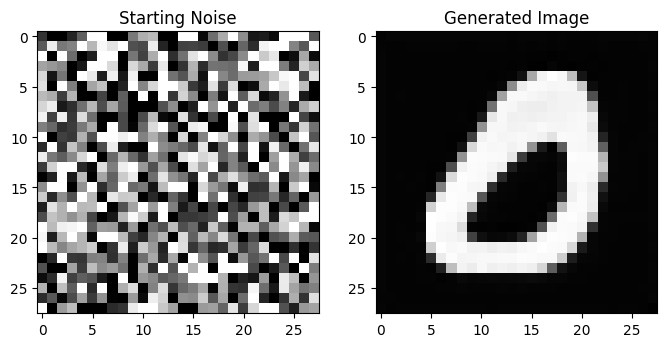

In [ ]:
model.eval()

# zero_matrix is (num_images, 784), so images are already flattened
# we can a standard random noise vector 
x_t = np.random.randn(784).astype(np.float32)  # (784,) - flattened vector
starting_noise = x_t.copy()  # (784,)

with torch.no_grad():
    for t in range(T, 0, -1):
        # Convert x_t to tensor (flattened: 784,)
        x_t_tensor = torch.tensor(x_t, dtype=torch.float32, device=device).unsqueeze(0)  # (1, 784)
        t_norm = t / T # normalize the time step to [0, 1]
        t_tensor = torch.tensor([t_norm], dtype=torch.float32, device=device)  # (1,)
        
        # predict noise (in flattened space)
        eps_pred = model(x_t_tensor, t_tensor).squeeze(0).cpu().numpy().astype(np.float32)  # (784,)
        
        # access the precomputed coefficients
        bt = beta_dict[t]
        at = alpha_dict[t]
        abar = alpha_bar_dict[t]
        sqrt_at = sqrt_alpha_dict[t]
        sqrt_one_minus_abar = sqrt_one_minus_alpha_bar_dict[t]
        
        # ddpm reverse step: x_{t-1} = (1/sqrt(alpha_t)) * (x_t - (beta_t/sqrt(1-alpha_bar_t)) * eps_pred)
        mu = (1.0 / sqrt_at) * (x_t - (bt / sqrt_one_minus_abar) * eps_pred)  # (784,),  flattened
        
        if t > 1:
            # stochastic DDPM sampling: add noise
            z = np.random.randn(784).astype(np.float32)  # (784,), flattened vector
            sigma = np.sqrt(bt)
            x_t = mu + sigma * z  # (784,), flattened
        else:
            # in the last step don't add noise
            x_t = mu  # (784,) 

# rehsape and transform for visualization
denoised_image = x_t.reshape(28, 28)
starting_noise_img = starting_noise.reshape(28, 28)
denoised_image_viz = (denoised_image + 1.0) / 2.0
starting_noise_img_viz = (starting_noise_img + 1.0) / 2.0

# Visualize the result
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(starting_noise_img_viz, cmap='gray', vmin=0, vmax=1)
plt.title('Starting Noise')
plt.subplot(1, 2, 2)
plt.imshow(denoised_image_viz, cmap='gray', vmin=0, vmax=1)
plt.title('Generated Image')
plt.show()

